# Binary Prediction with a Rainfall Dataset

第一组特征提取的信息比例: 96.60%
第一组特征提取的信息比例: 96.47%
第二组特征提取的信息比例: 98.66%
第二组特征提取的信息比例: 98.69%
原始数据形状  Counter({1: 1160, 0: 373})
过采样后数据形状  Counter({1: 1160, 0: 1160})
Optimizing LightGBM...
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.8878    | 0.6124    | 0.2857    | 4.464     | 55.92     | 37.8      | 13.12     | 0.1523    | 0.8796    | 0.6803    |
| 2         | 0.8524    | 0.7124    | 0.01597   | 4.94      | 69.95     | 40.62     | 13.64     | 0.2651    | 0.3738    | 0.6574    |
| 3         | 0.8693    | 0.6296    | 0.09446   | 4.224     | 28.37     | 44.61     | 17.33     | 0.5105    | 0.8067    | 0.5599    |
| 4         | 0.8753    | 0.6543    | 0.1818    | 3.093     | 56.45     | 38.53     | 11.3      | 0.954     | 0.9691    | 0.7425    |
| 5         | 0.

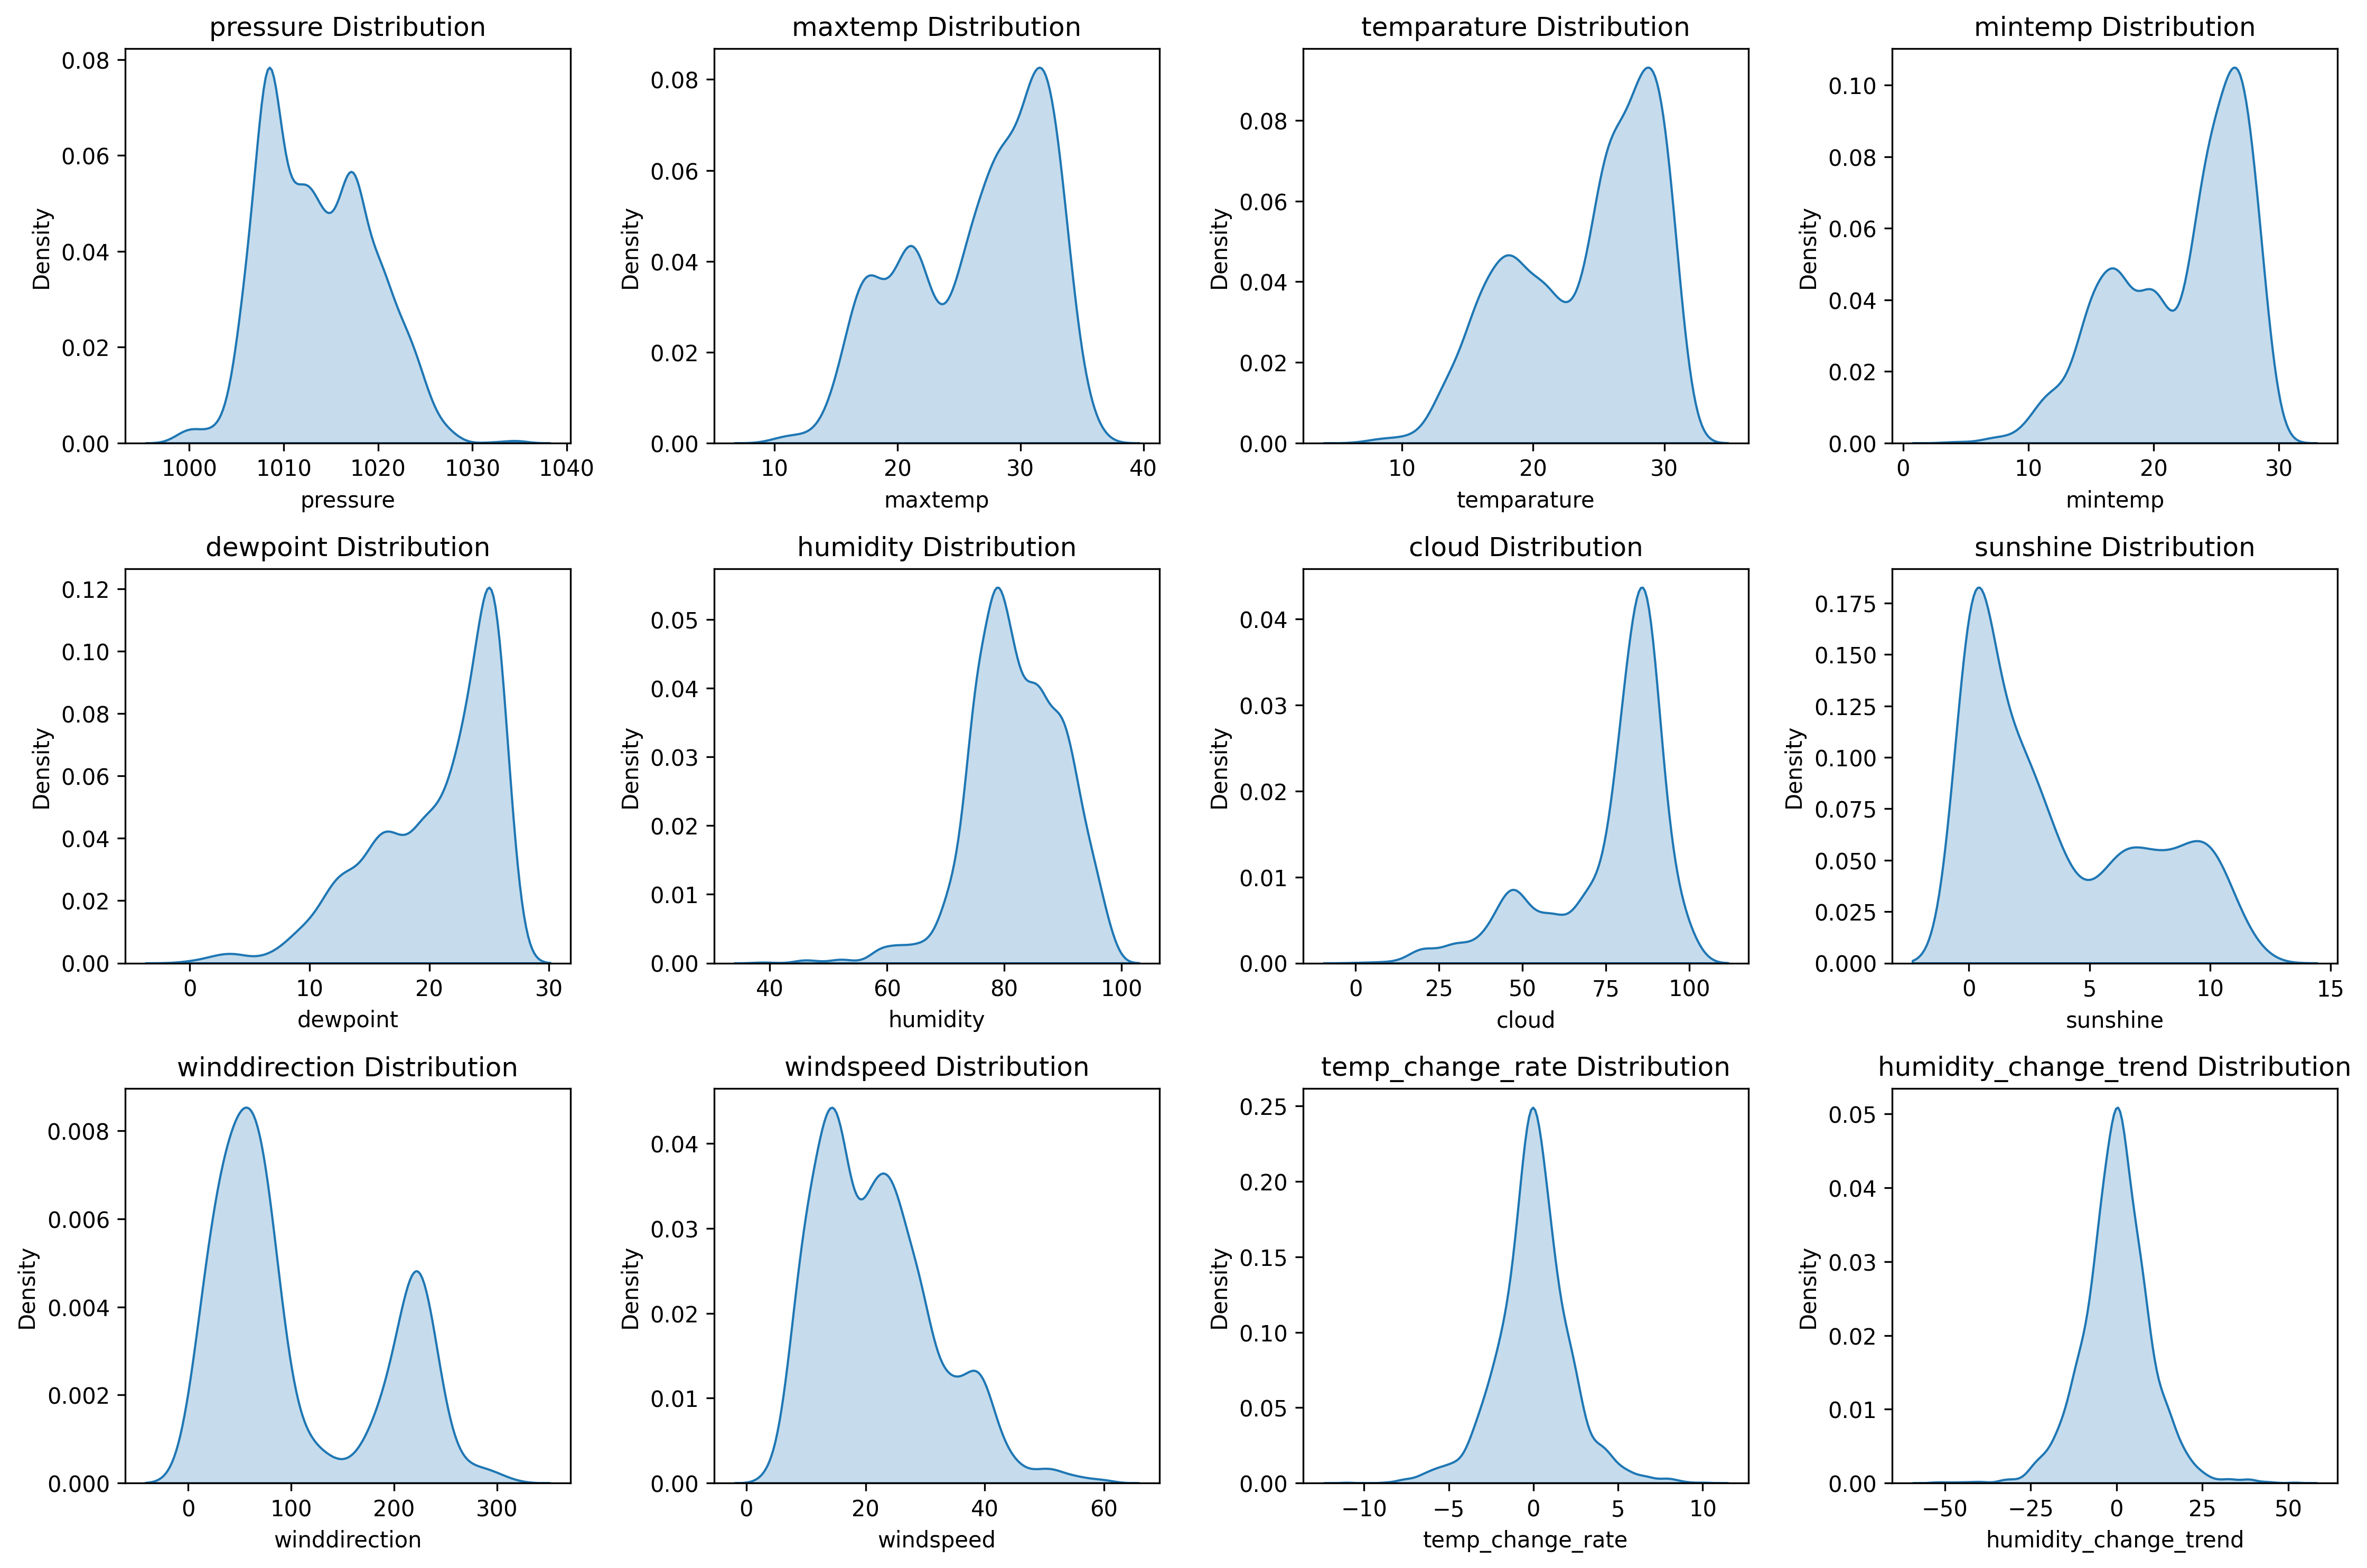

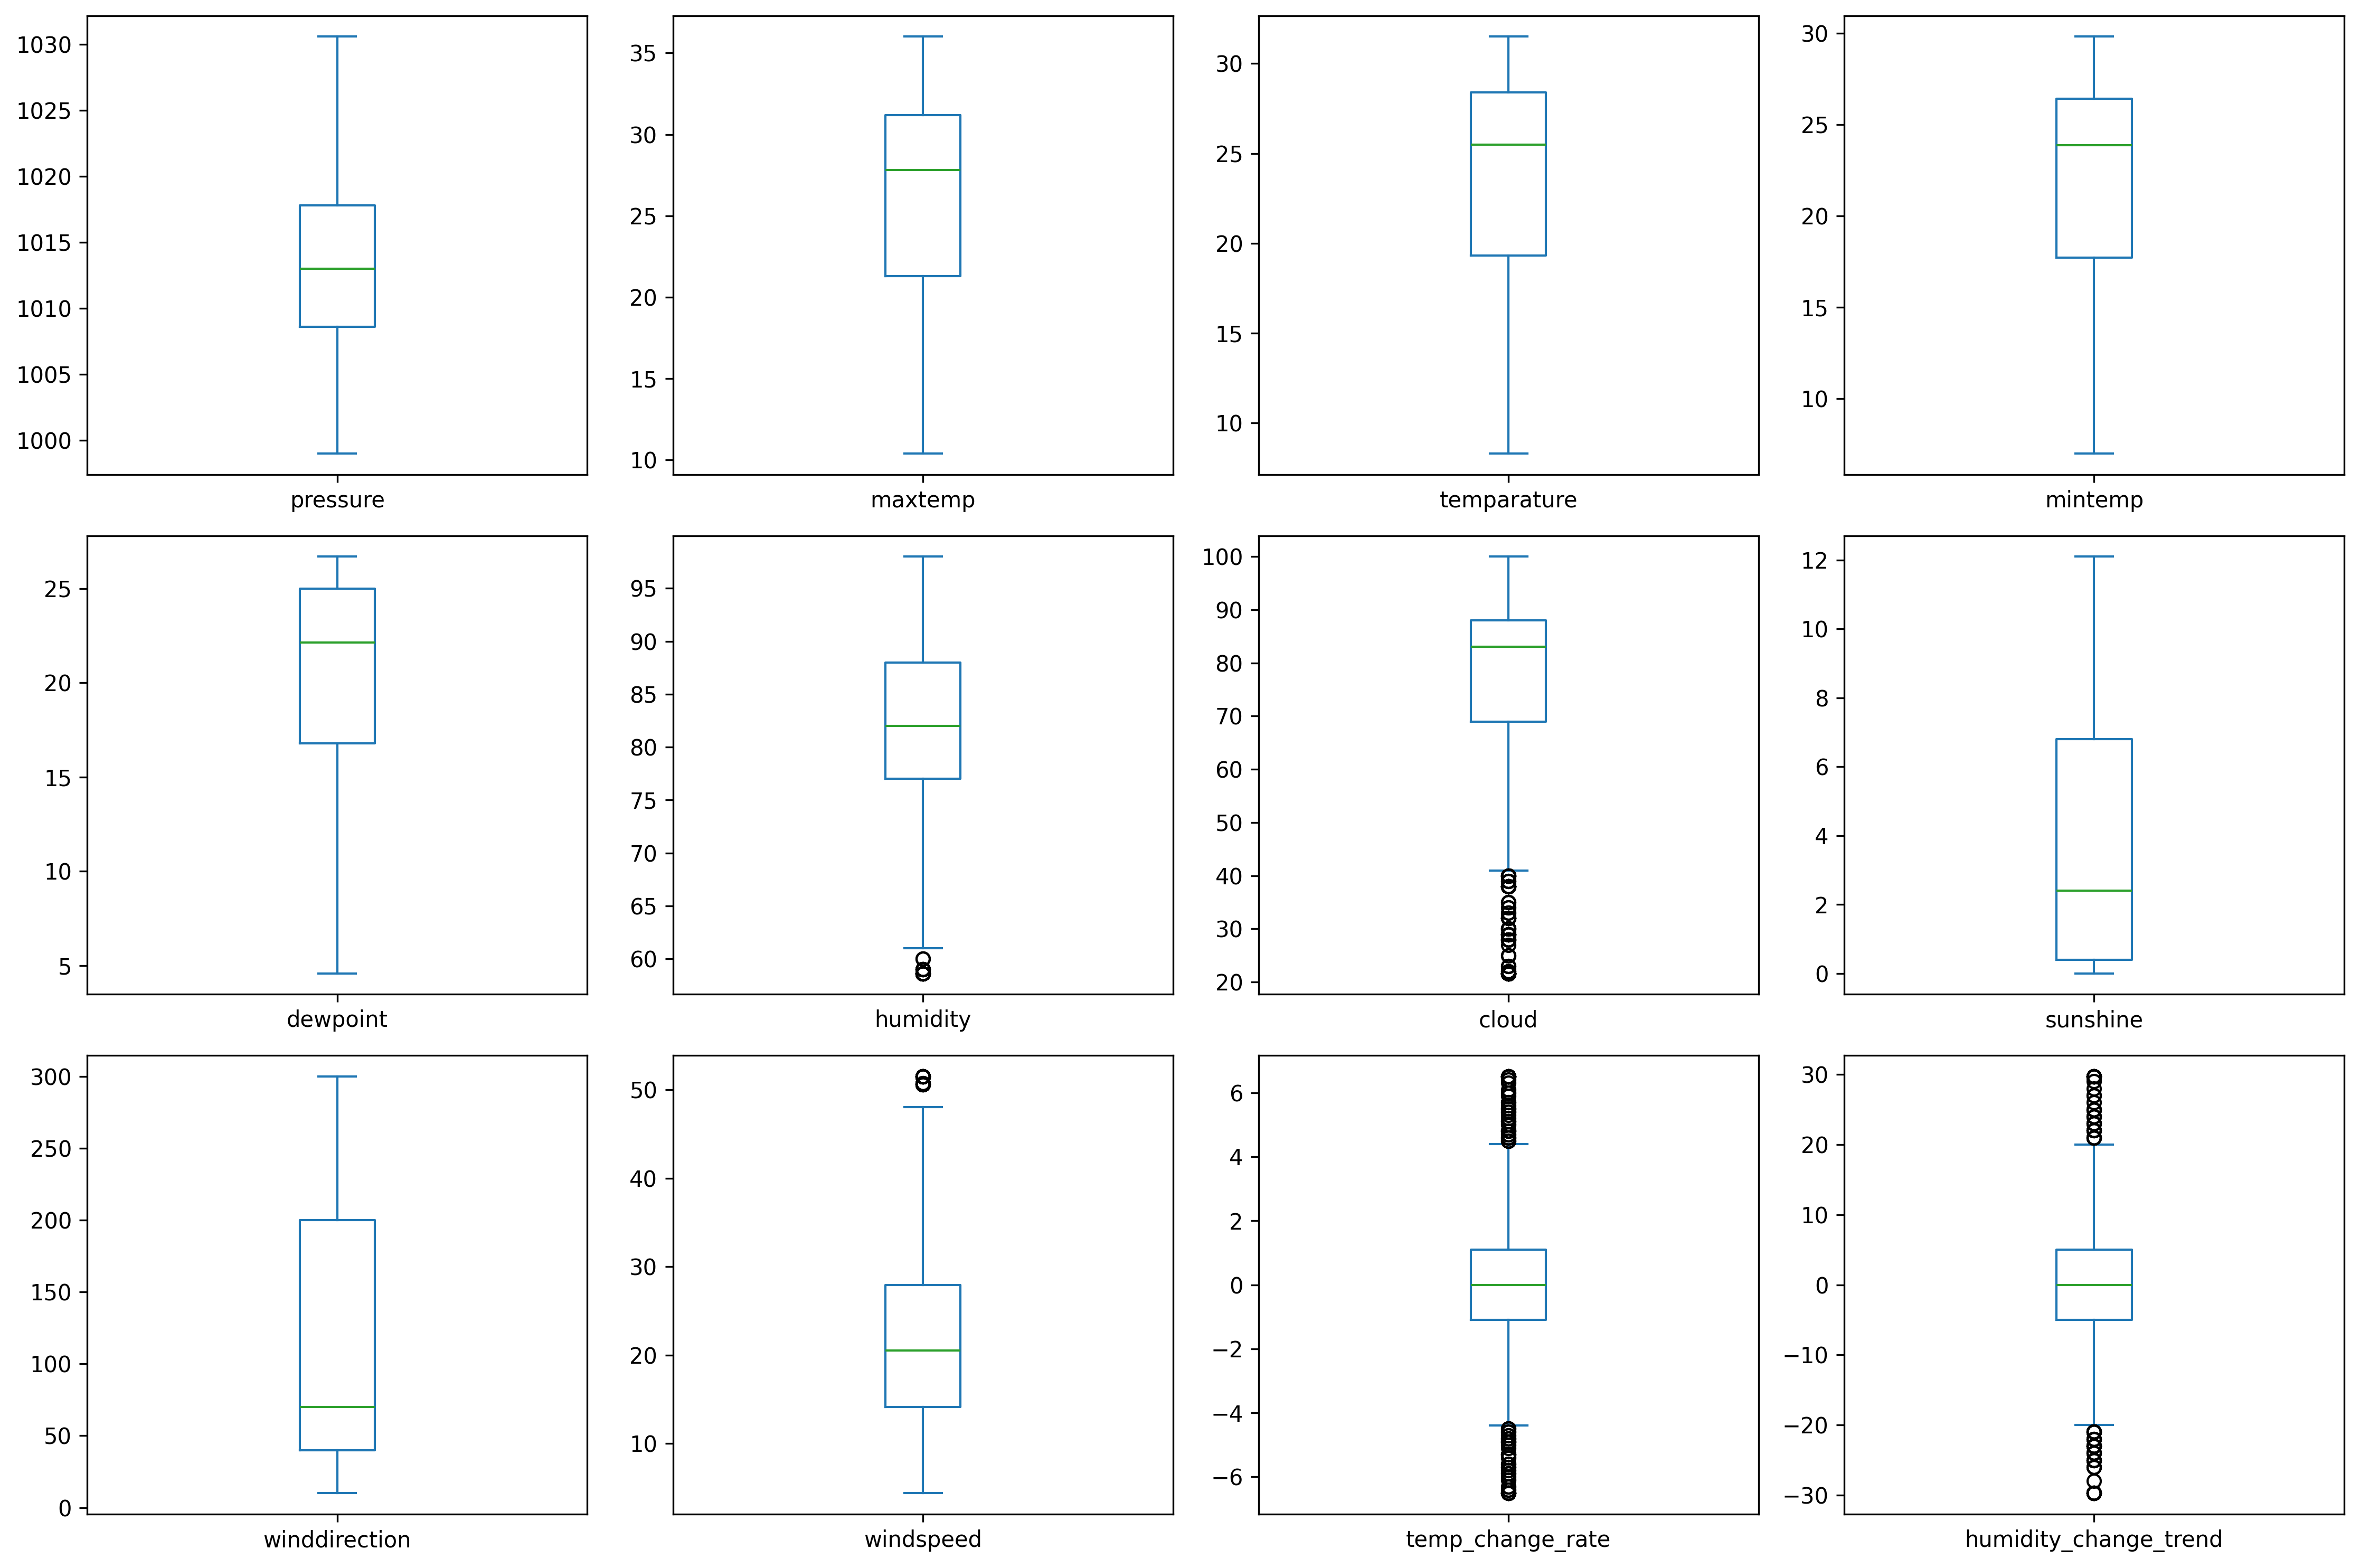

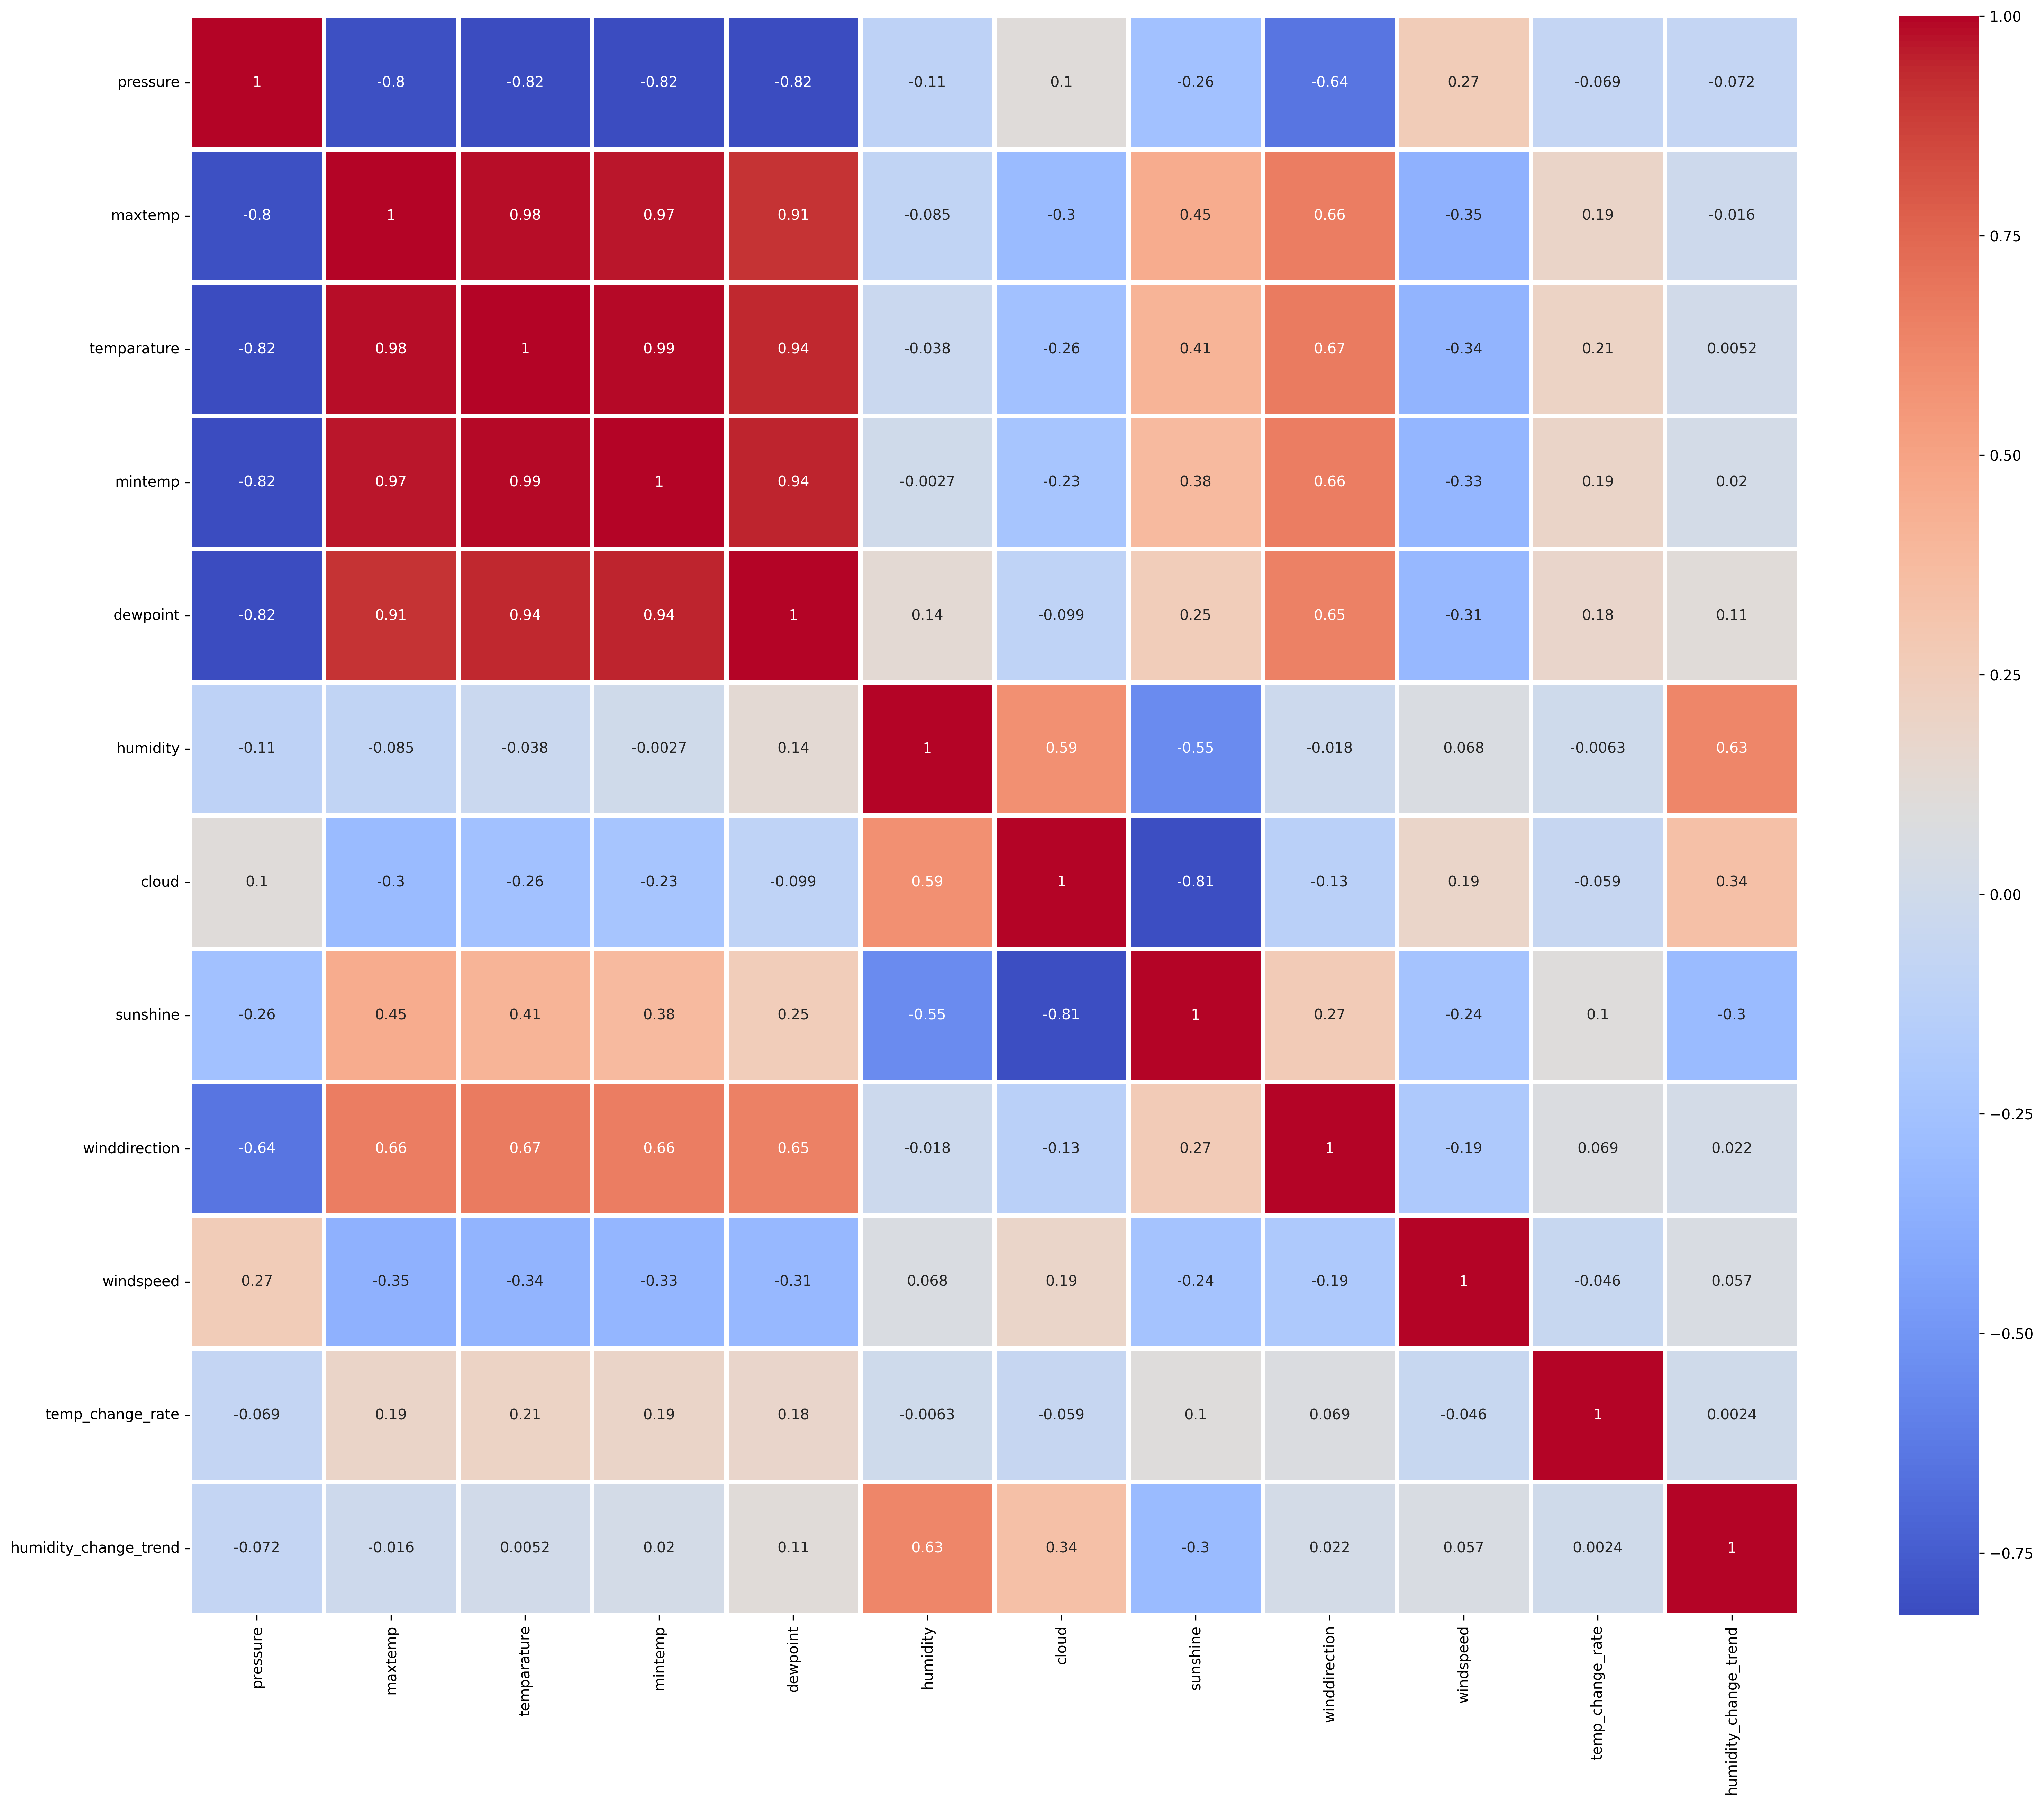

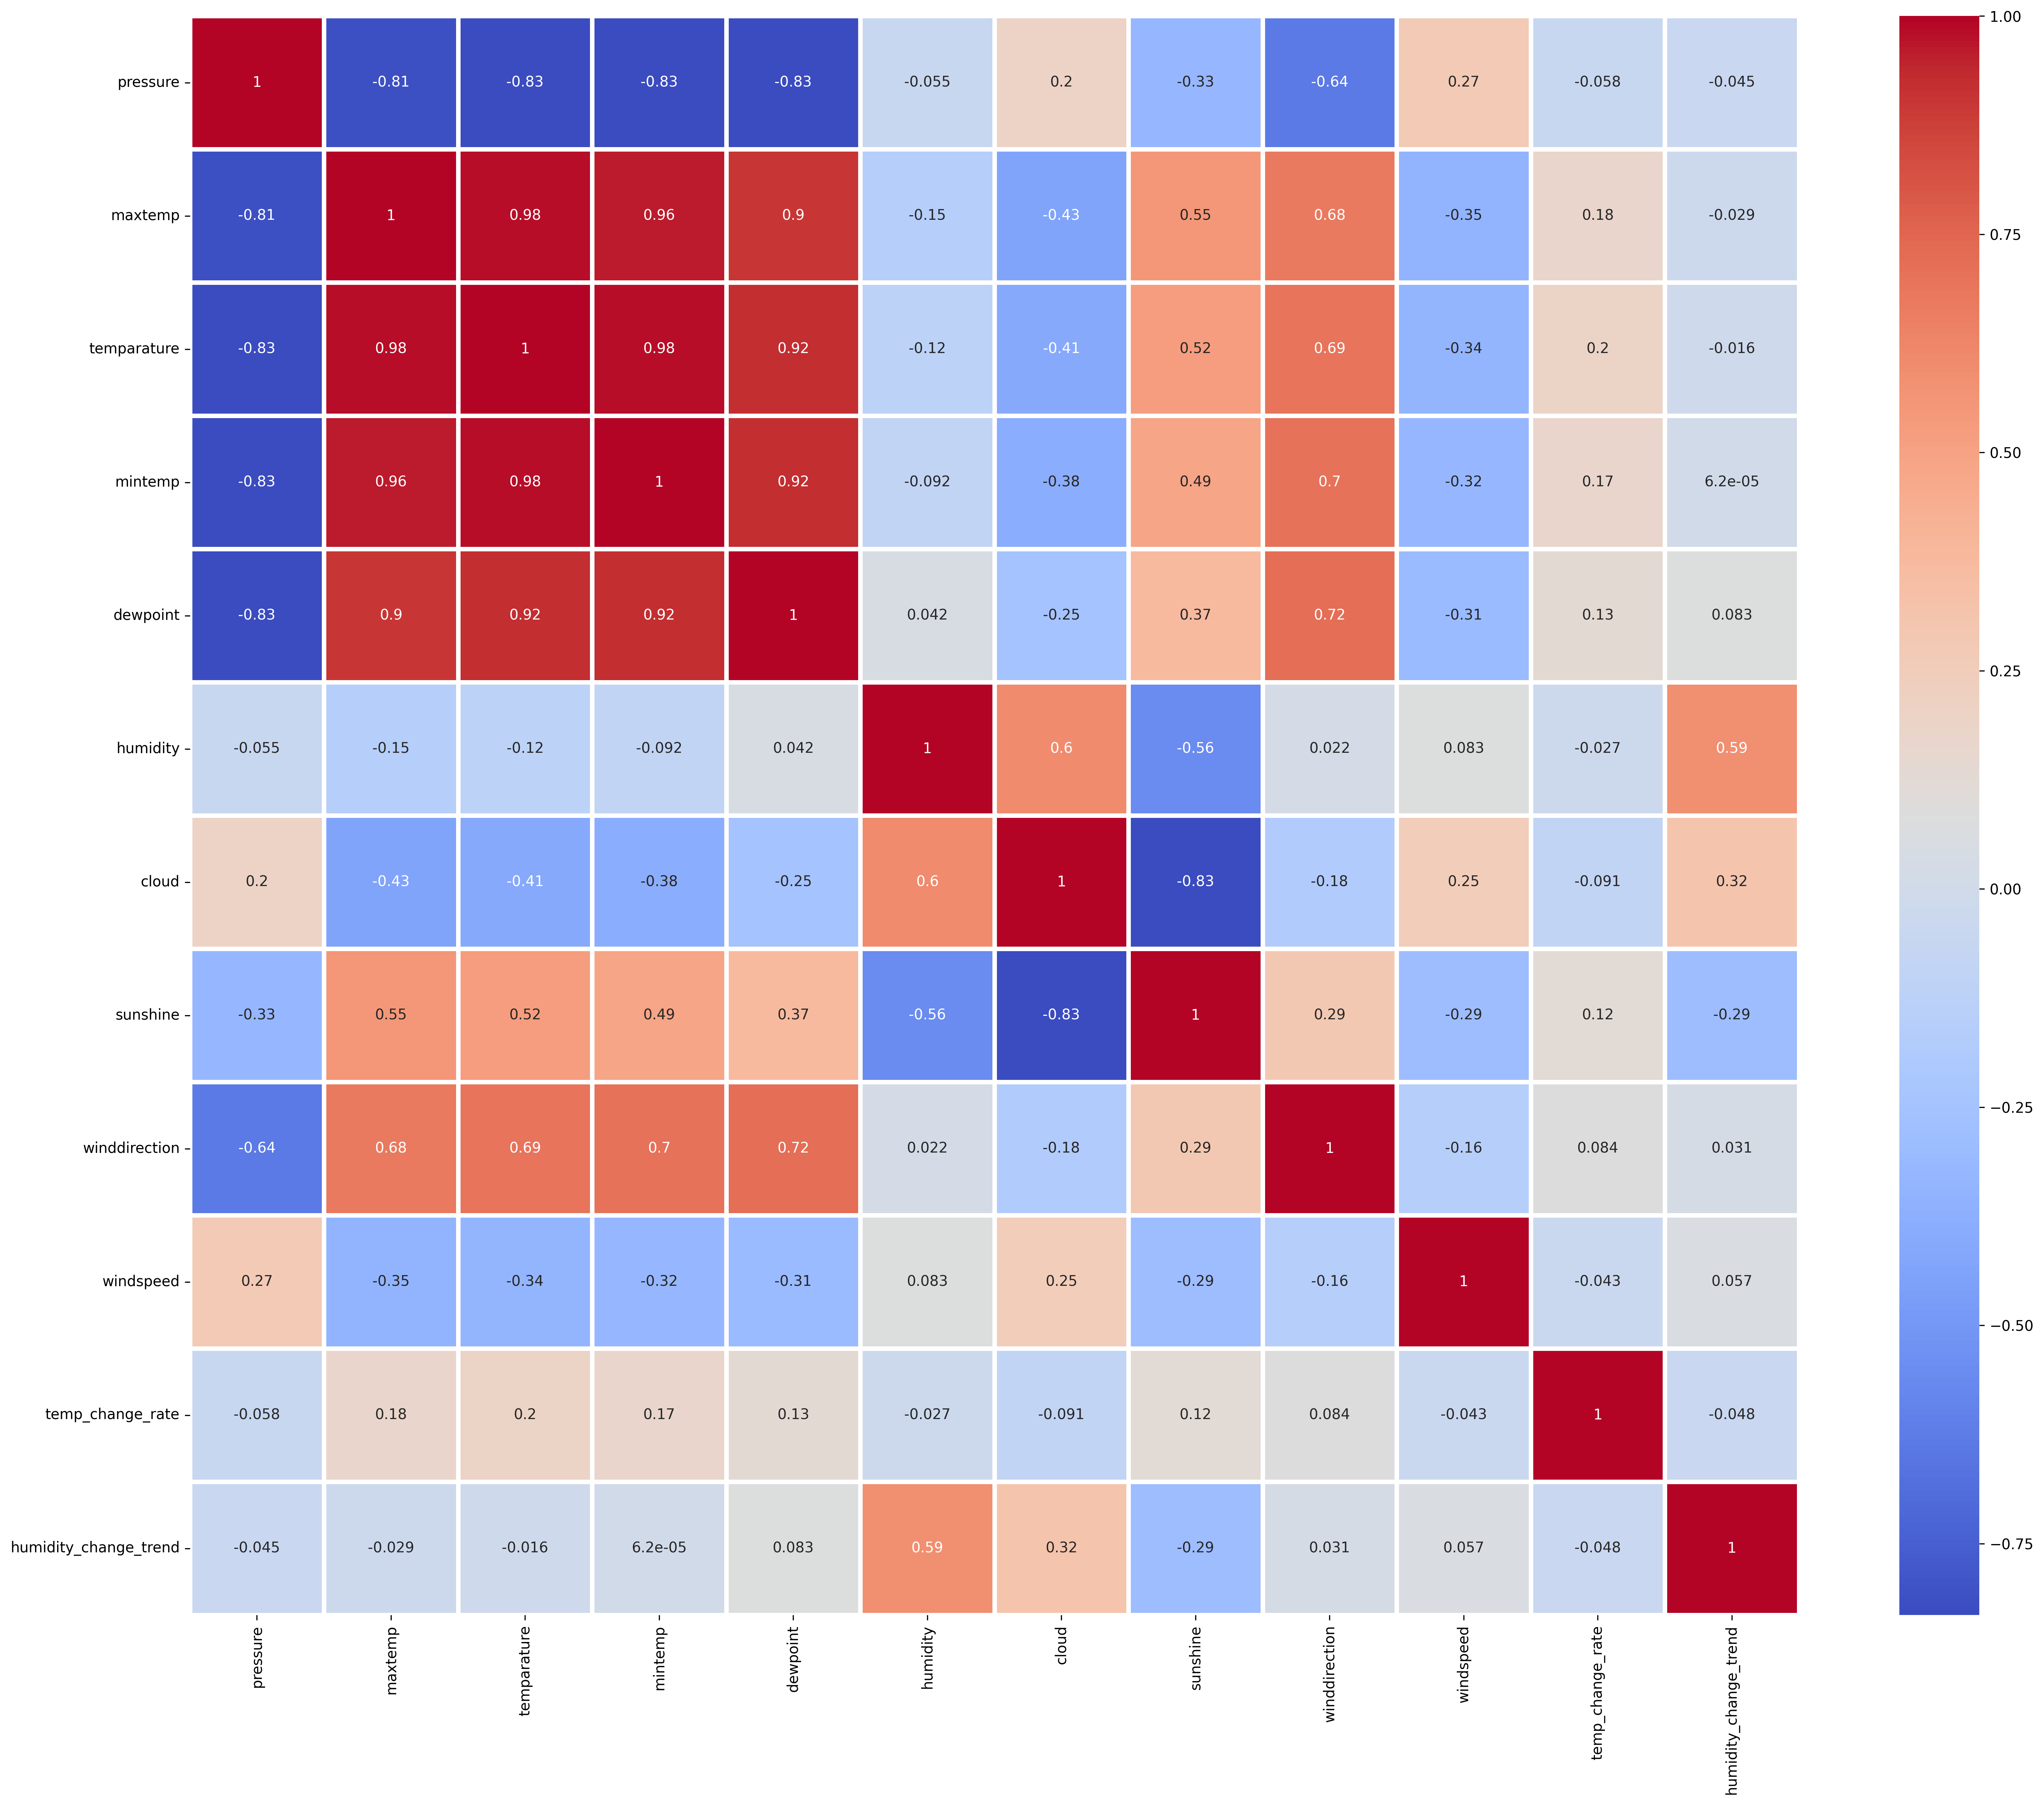

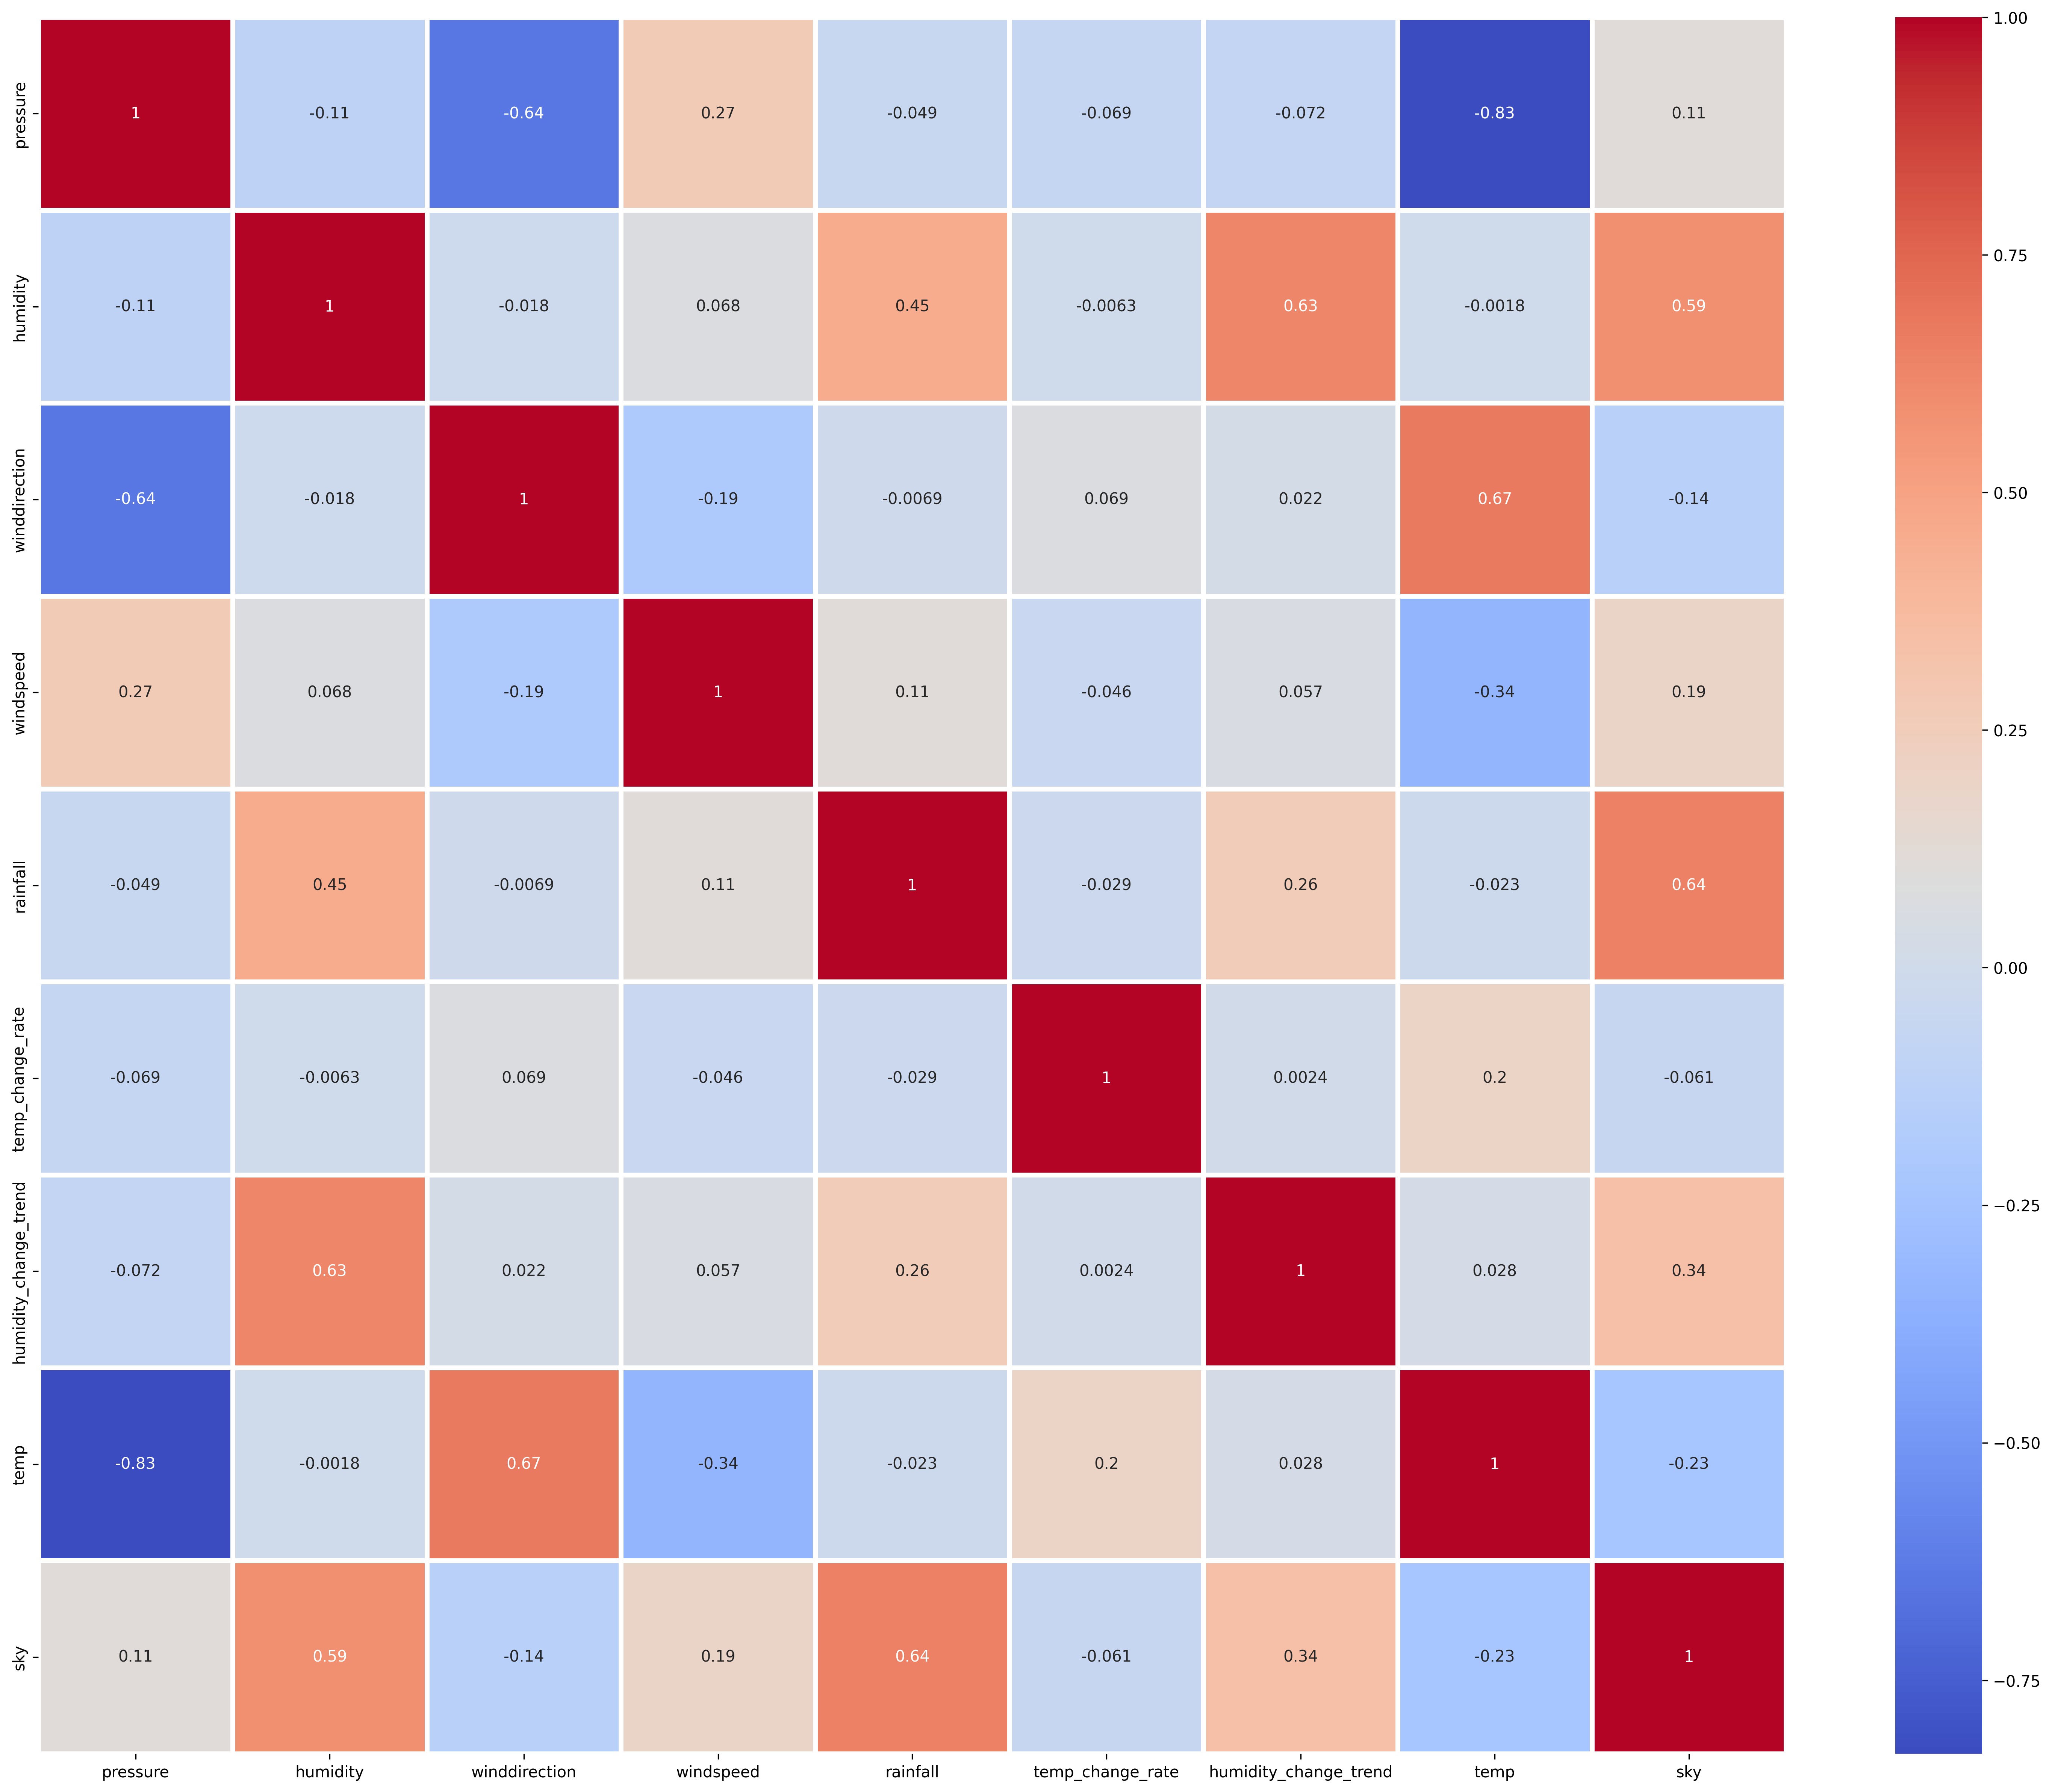

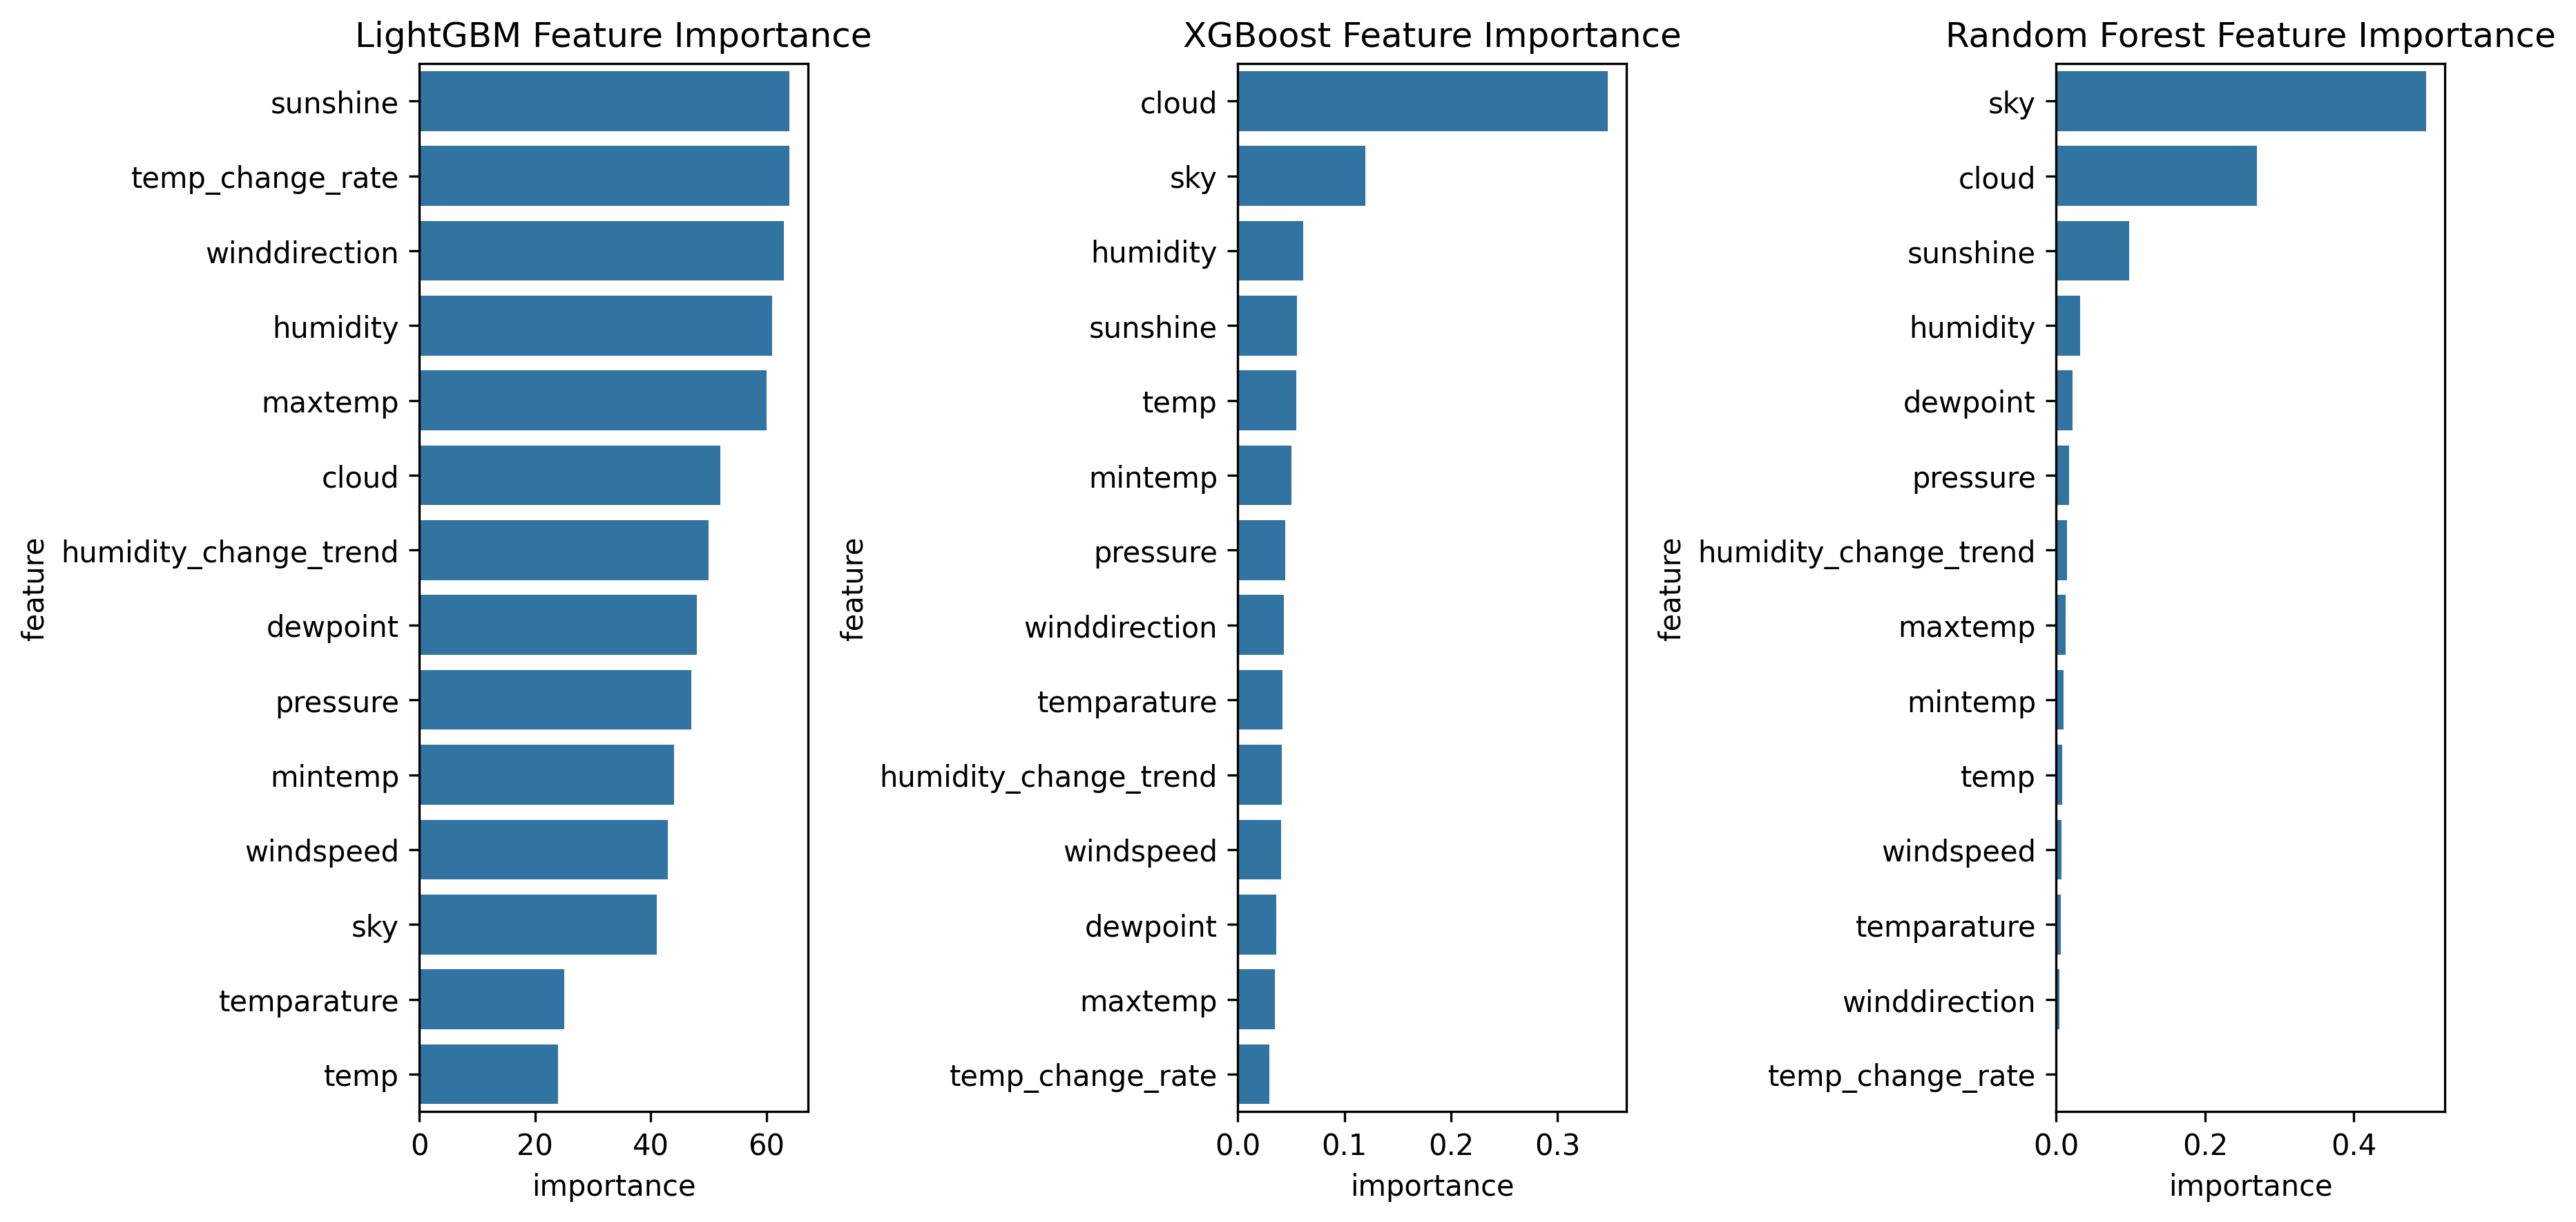

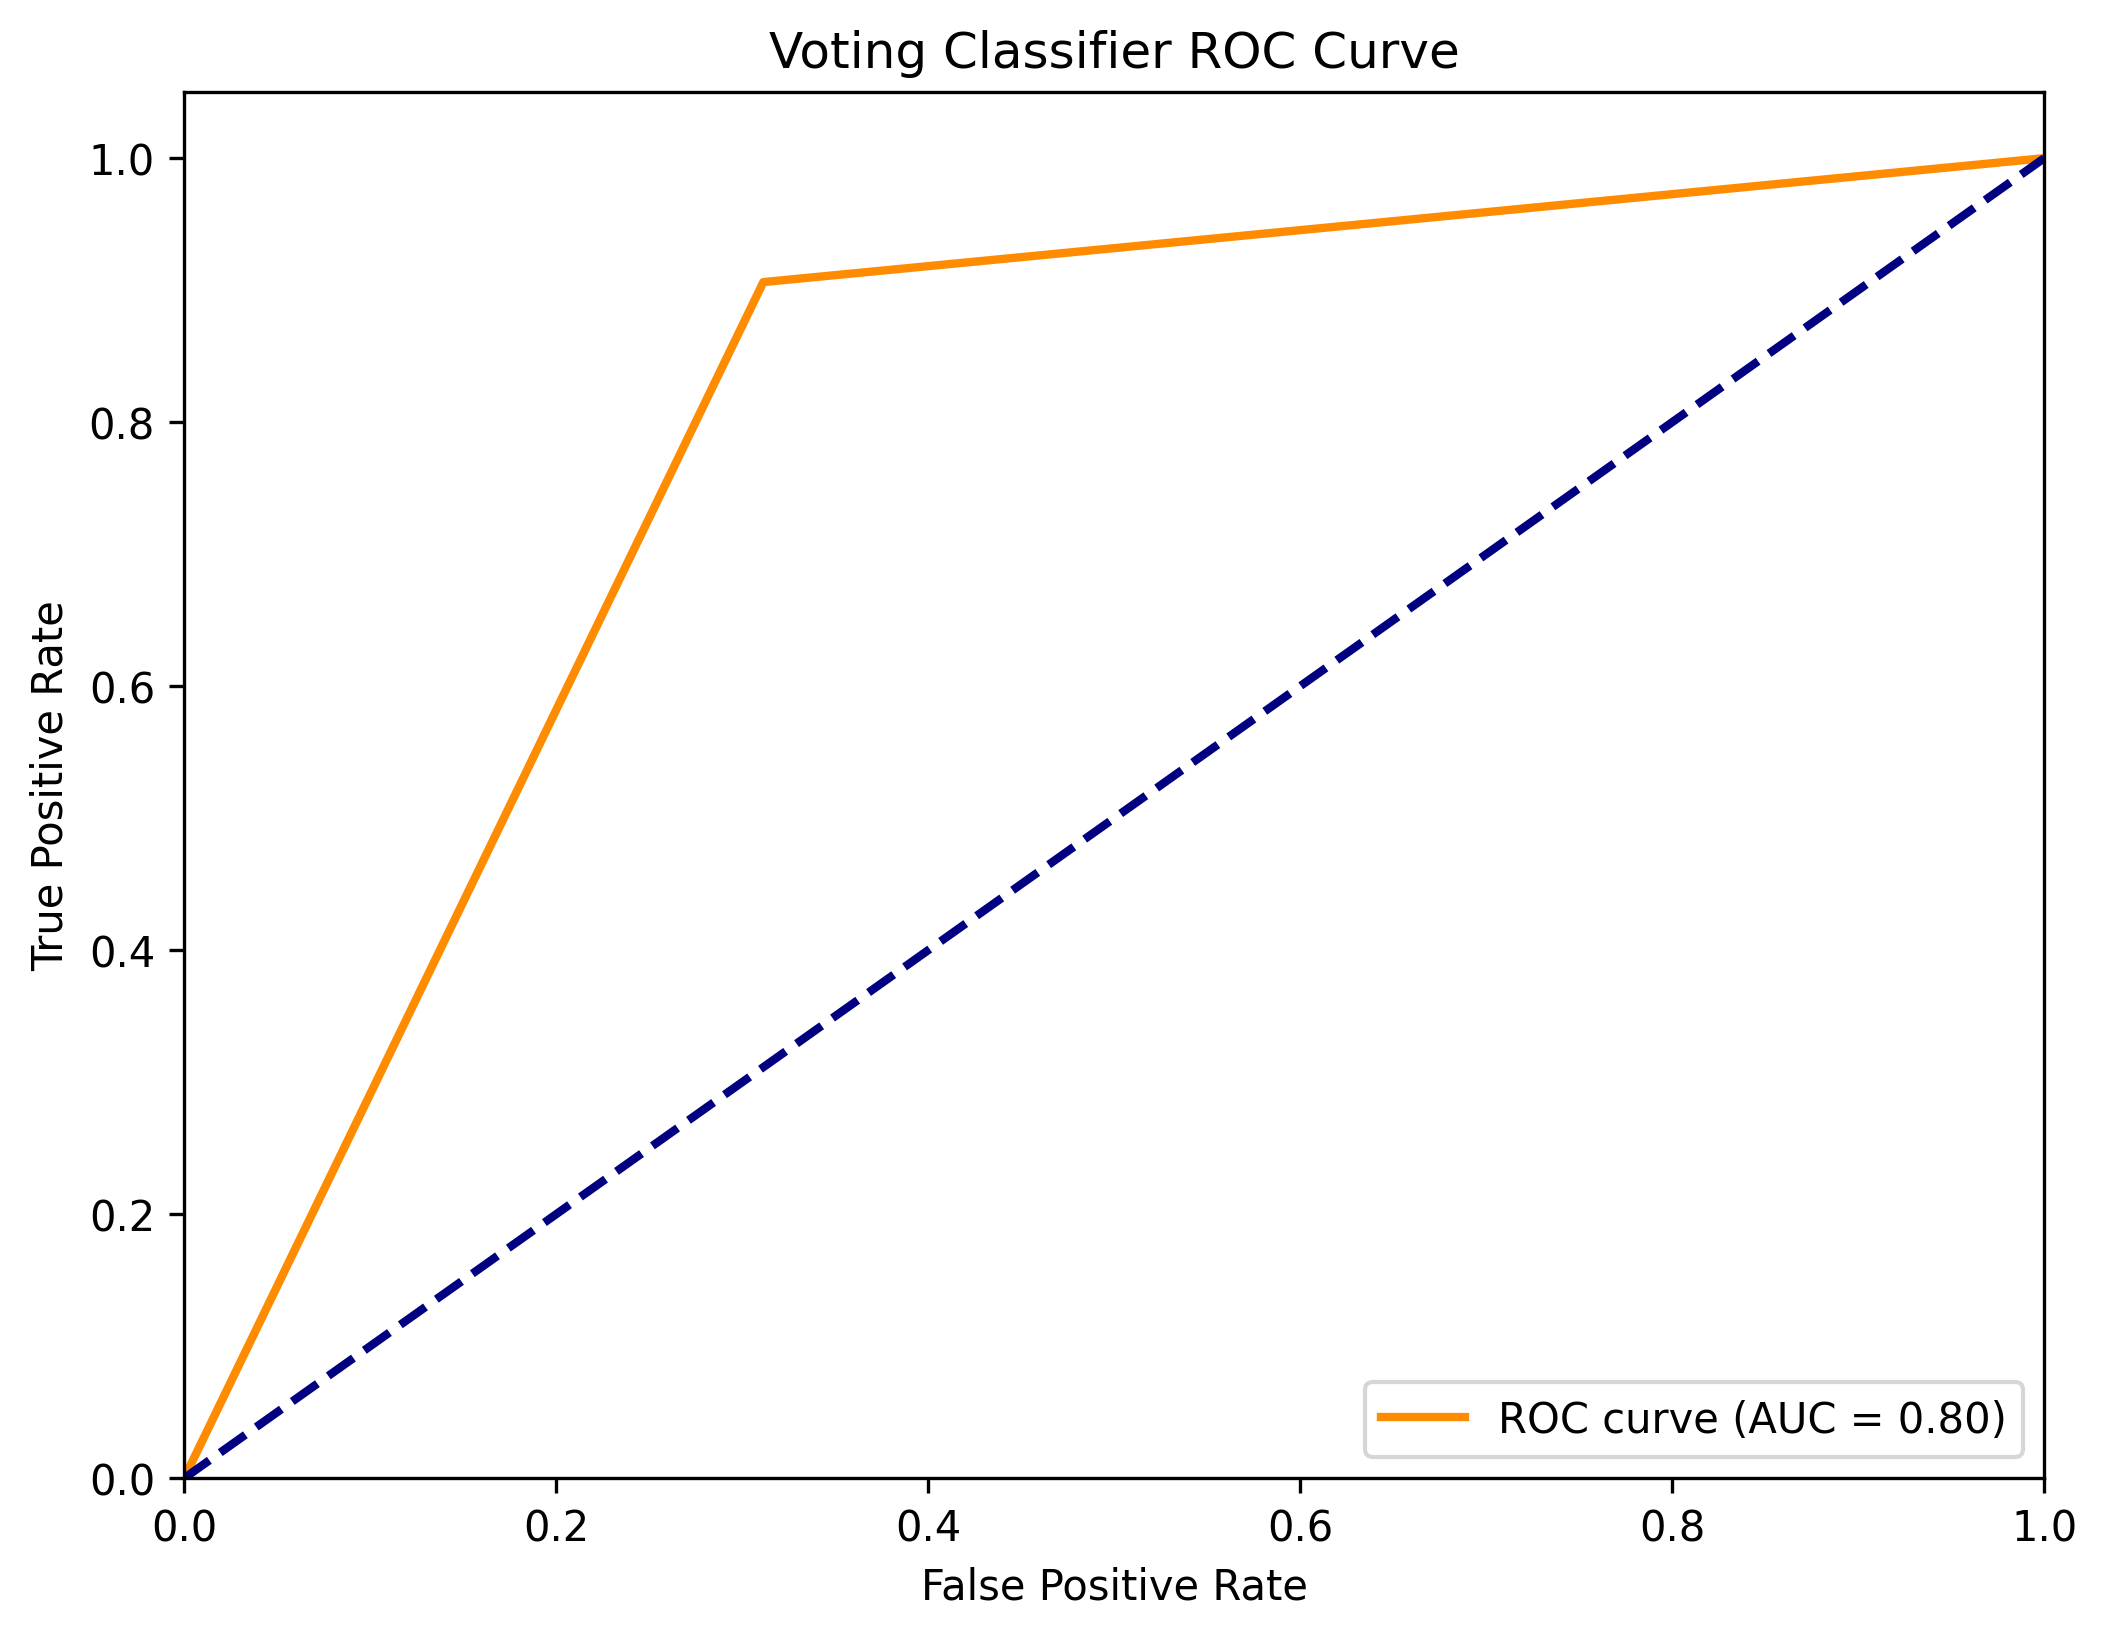

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
from bayes_opt import BayesianOptimization

# 数据导入
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 构造新变量
# 构造温度变化率
data['temp_change_rate'] = data['temparature'].diff()
data['temp_change_rate'] = data['temp_change_rate'].fillna(0)  # 将第一行的 NaN 填充为 0

# 构造湿度变化趋势
data['humidity_change_trend'] = data['humidity'].diff()
data['humidity_change_trend'] = data['humidity_change_trend'].fillna(0)  # 将第一行的 NaN 填充为 0

# 中位数插补缺失值
data['temp_change_rate'] = data['temp_change_rate'].fillna(data['temp_change_rate'].median())
data['humidity_change_trend'] = data['humidity_change_trend'].fillna(data['humidity_change_trend'].median())

test['temp_change_rate'] = test['temparature'].diff()
test['temp_change_rate'] = test['temp_change_rate'].fillna(0)  # 将第一行的 NaN 填充为 0
test['humidity_change_trend'] = test['humidity'].diff()
test['humidity_change_trend'] = test['humidity_change_trend'].fillna(0)  # 将第一行的 NaN 填充为 0
test['temp_change_rate'] = test['temp_change_rate'].fillna(test['temp_change_rate'].median())
test['humidity_change_trend'] = test['humidity_change_trend'].fillna(test['humidity_change_trend'].median())

# 特征工程
# 缺失值检测
# print('全部缺失值数量：', data.isnull().sum())

# 分布探索
features = ['pressure', 'maxtemp', 'temparature', 'mintemp',
            'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
            'windspeed', 'temp_change_rate', 'humidity_change_trend']

plt.rcParams['figure.dpi'] = 300
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()
for i, feature in enumerate(features):
    sns.kdeplot(data[feature], ax=axes[i], shade=True)
    axes[i].set_title(f'{feature} Distribution')
plt.tight_layout()
plt.savefig('特征分布.png')

# 3sigma处理
for feature in features:
    mean = data[feature].mean()
    std = data[feature].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    # 将异常值替换为上下边界值
    data[feature] = data[feature].clip(lower=lower_bound, upper=upper_bound)

for feature in features:
    mean = test[feature].mean()
    std = test[feature].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    # 将异常值替换为上下边界值
    test[feature] = test[feature].clip(lower=lower_bound, upper=upper_bound)

# 箱线图验证
plt.rcParams['figure.dpi'] = 300
data[features].plot(kind='box', subplots=True, layout=(3, 4), figsize=(15, 10))
plt.tight_layout()
plt.savefig('箱线图.png')

# 特征过滤
# 相关性分析
# Pearson相关系数
corr = data[features].corr()
f, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(corr, ax=ax, annot=True, linewidths=3, cmap='coolwarm')
plt.savefig(fname="Pearson相关系数热图.png")

# Spearman相关系数
corr = data[features].corr(method='spearman')
f, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(corr, ax=ax, annot=True, linewidths=3, cmap='coolwarm')
plt.savefig(fname="Spearman相关系数热图.png")

# 主成分分析
# 第一组特征：'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint'
group1_features = ['maxtemp', 'temparature', 'mintemp', 'dewpoint']
pca1 = PCA(n_components=1)
data['temp'] = pca1.fit_transform(data[group1_features])
explained_variance_ratio1 = pca1.explained_variance_ratio_[0]
print(f"第一组特征提取的信息比例: {explained_variance_ratio1 * 100:.2f}%")

group1_features = ['maxtemp', 'temparature', 'mintemp', 'dewpoint']
pca1 = PCA(n_components=1)
test['temp'] = pca1.fit_transform(test[group1_features])
explained_variance_ratio1 = pca1.explained_variance_ratio_[0]
print(f"第一组特征提取的信息比例: {explained_variance_ratio1 * 100:.2f}%")

# 第二组特征：'cloud', 'sunshine'
group2_features = ['cloud', 'sunshine']
pca2 = PCA(n_components=1)
data['sky'] = pca2.fit_transform(data[group2_features])
explained_variance_ratio2 = pca2.explained_variance_ratio_[0]
print(f"第二组特征提取的信息比例: {explained_variance_ratio2 * 100:.2f}%")

group2_features = ['cloud', 'sunshine']
pca2 = PCA(n_components=1)
test['sky'] = pca2.fit_transform(test[group2_features])
explained_variance_ratio2 = pca2.explained_variance_ratio_[0]
print(f"第二组特征提取的信息比例: {explained_variance_ratio2 * 100:.2f}%")

# data.drop(group1_features + group2_features, axis=1, inplace=True)
# test.drop(group1_features + group2_features, axis=1, inplace=True)

features = ['pressure', 'humidity', 'winddirection', 'windspeed', 'rainfall',
            'temp_change_rate', 'humidity_change_trend', 'temp', 'sky']

# Pearson相关系数
corr = data[features].corr()
f, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(corr, ax=ax, annot=True, linewidths=3, cmap='coolwarm')
plt.savefig(fname="PCA后Pearson相关系数热图.png")

# 归一化
X = data.drop(['rainfall', 'id', 'day'], axis=1)
y = data['rainfall']
# Min-Max归一化
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

input_data = test.drop(['id', 'day'], axis=1)
input_data = scaler.transform(input_data)

# 数据划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 过采样
print('原始数据形状  {}'.format(Counter(y_train)))
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print('过采样后数据形状  {}'.format(Counter(y_train)))

# -------------------- 贝叶斯优化函数定义 --------------------
def optimize_model(model_name, X, y, n_iter=300):
    # 定义参数搜索空间
    if model_name == 'lgb':
        pbounds = {
            'n_estimators': (30, 80),
            'num_leaves': (10, 30),
            'learning_rate': (0.01, 0.3),
            'max_depth': (3, 5),
            'min_child_samples': (20, 80),
            'subsample': (0.5, 0.8),
            'colsample_bytree': (0.5, 0.8),
            'reg_alpha': (0.1, 1),
            'reg_lambda': (0.1, 1)
        }
    elif model_name == 'xgb':
        pbounds = {
            'n_estimators': (30, 80),
            'max_depth': (3, 5),
            'learning_rate': (0.01, 0.3),
            'subsample': (0.5, 0.8),
            'colsample_bytree': (0.5, 0.8),
            'gamma': (0.1, 1),
            'reg_alpha': (0.1, 1),
            'reg_lambda': (0.1, 1)
        }
    elif model_name == 'rf':
        pbounds = {
            'n_estimators': (30, 80),
            'max_depth': (3, 5),
            'min_samples_split': (5, 15),
            'min_samples_leaf': (2, 8),
            'max_features': (0.5, 0.8)
        }
    
    # 定义目标函数
    def target(**params):
        if model_name == 'lgb':
            model = lgb.LGBMClassifier(
                objective='binary',
                num_leaves=int(params['num_leaves']),
                learning_rate=params['learning_rate'],
                max_depth=int(params['max_depth']),
                min_child_samples=int(params['min_child_samples']),
                subsample=params['subsample'],
                colsample_bytree=params['colsample_bytree'],
                reg_alpha=params['reg_alpha'],
                reg_lambda=params['reg_lambda'],
                verbose=-1
            )
        elif model_name == 'xgb':
            model = xgb.XGBClassifier(
                objective='binary:logistic',
                max_depth=int(params['max_depth']),
                learning_rate=params['learning_rate'],
                subsample=params['subsample'],
                colsample_bytree=params['colsample_bytree'],
                gamma=params['gamma'],
                reg_alpha=params['reg_alpha'],
                reg_lambda=params['reg_lambda']
            )
        elif model_name == 'rf':
            model = RandomForestClassifier(
                n_estimators=int(params['n_estimators']),
                max_depth=int(params['max_depth']),
                min_samples_split=int(params['min_samples_split']),
                min_samples_leaf=int(params['min_samples_leaf']),
                max_features=params['max_features'],
                bootstrap=True
            )
        
        # 交叉验证
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = []
        for train_idx, val_idx in cv.split(X, y):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # 应用SMOTE
            smote = SMOTE(random_state=42)
            X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
            
            model.fit(X_train_res, y_train_res)
            y_pred = model.predict(X_val)
            scores.append(f1_score(y_val, y_pred))
        
        return np.mean(scores)
    
    # 运行贝叶斯优化
    optimizer = BayesianOptimization(
        f=target,
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )
    optimizer.maximize(init_points=150, n_iter=n_iter)
    return optimizer.max

# -------------------- 执行贝叶斯优化 --------------------
# 优化LightGBM
print("Optimizing LightGBM...")
lgb_best = optimize_model('lgb', X_train, y_train)
best_lgb_params = lgb_best['params']
best_lgb_params.update({
    'n_estimators': int(best_lgb_params['n_estimators']),
    'num_leaves': int(best_lgb_params['num_leaves']),
    'max_depth': int(best_lgb_params['max_depth']),
    'min_child_samples': int(best_lgb_params['min_child_samples']),
    'objective': 'binary',
    'verbose': -1
})

# 优化XGBoost
print("Optimizing XGBoost...")
xgb_best = optimize_model('xgb', X_train, y_train)
best_xgb_params = xgb_best['params']
for param in ['n_estimators', 'max_depth']:
    best_xgb_params[param] = int(best_xgb_params[param])
best_xgb_params.update({
    'objective': 'binary:logistic'
})

# 优化随机森林
print("Optimizing Random Forest...")
rf_best = optimize_model('rf', X_train, y_train)
best_rf_params = rf_best['params']
best_rf_params.update({
    'n_estimators': int(best_rf_params['n_estimators']),
    'max_depth': int(best_rf_params['max_depth']),
    'min_samples_split': int(best_rf_params['min_samples_split']),
    'min_samples_leaf': int(best_rf_params['min_samples_leaf'])
})

# -------------------- 构建优化后的模型 --------------------
best_lgb_model = lgb.LGBMClassifier(**best_lgb_params)
best_xgb_model = xgb.XGBClassifier(**best_xgb_params)
best_rf_model = RandomForestClassifier(**best_rf_params)

print("LightGBM最佳参数:", best_lgb_params)
print("XGBoost最佳参数:", best_xgb_params)
print("随机森林最佳参数:", best_rf_params)


# -------------------- 计算特征重要性并筛选特征 --------------------
feature_names = data.drop(['rainfall', 'id', 'day'], axis=1).columns

# 训练模型以获取特征重要性
best_lgb_model.fit(X_train, y_train)
best_xgb_model.fit(X_train, y_train)
best_rf_model.fit(X_train, y_train)

# LightGBM 特征重要性
lgb_importance = best_lgb_model.feature_importances_
lgb_importance_df = pd.DataFrame({'feature': feature_names, 'importance': lgb_importance})
lgb_importance_df = lgb_importance_df.sort_values(by='importance', ascending=False)

# XGBoost 特征重要性
xgb_importance = best_xgb_model.feature_importances_
xgb_importance_df = pd.DataFrame({'feature': feature_names, 'importance': xgb_importance})
xgb_importance_df = xgb_importance_df.sort_values(by='importance', ascending=False)

# 随机森林特征重要性
rf_importance = best_rf_model.feature_importances_
rf_importance_df = pd.DataFrame({'feature': feature_names, 'importance': rf_importance})
rf_importance_df = rf_importance_df.sort_values(by='importance', ascending=False)

# 可视化特征重要性
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='importance', y='feature', data=lgb_importance_df)
plt.title('LightGBM Feature Importance')

plt.subplot(1, 3, 2)
sns.barplot(x='importance', y='feature', data=xgb_importance_df)
plt.title('XGBoost Feature Importance')

plt.subplot(1, 3, 3)
sns.barplot(x='importance', y='feature', data=rf_importance_df)
plt.title('Random Forest Feature Importance')

plt.tight_layout()
plt.savefig('feature_importance.png')

# 特征筛选：选择每个模型中最重要的前5个特征
top_features_lgb = lgb_importance_df.head(8)['feature'].tolist()
top_features_xgb = xgb_importance_df.head(8)['feature'].tolist()
top_features_rf = rf_importance_df.head(8)['feature'].tolist()

# 合并所有重要特征
all_top_features = list(set(top_features_lgb + top_features_xgb + top_features_rf))

# 使用筛选后的特征重新构建数据集
X_new = data[all_top_features]
input_data_new = test[all_top_features]

# 重新进行归一化
scaler_new = MinMaxScaler()
X_new = scaler_new.fit_transform(X_new)
input_data_new = scaler_new.transform(input_data_new)

# 重新划分数据集
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size=0.3, random_state=42)

# 重新进行过采样
print('筛选特征后原始数据形状  {}'.format(Counter(y_train_new)))
smote = SMOTE(random_state=42)
X_train_new, y_train_new = smote.fit_resample(X_train_new, y_train_new)
print('筛选特征后过采样后数据形状  {}'.format(Counter(y_train_new)))

# 构建优化后的模型（使用之前贝叶斯优化得到的参数）
best_lgb_model = lgb.LGBMClassifier(**best_lgb_params)
best_xgb_model = xgb.XGBClassifier(**best_xgb_params)
best_rf_model = RandomForestClassifier(**best_rf_params)

# 贝叶斯优化权重
def target(w1, w2, w3):
    weights = [w1, w2, w3]
    voting_model = VotingClassifier(
        estimators=[('lgb', best_lgb_model), ('xgb', best_xgb_model), ('rf', best_rf_model)],
        voting='soft',
        weights=weights
    )
    # 交叉验证评估F1分数
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        voting_model.fit(X_tr, y_tr)
        y_pred = voting_model.predict(X_val)
        scores.append(f1_score(y_val, y_pred))
    return np.mean(scores)

# 定义权重搜索范围（0.5~2倍默认值）
pbounds = {
    'w1': (0.5, 2.0),
    'w2': (0.5, 2.0),
    'w3': (0.5, 2.0)
}

optimizer = BayesianOptimization(f=target, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=30, n_iter=70)
best_weights = optimizer.max['params']
print("最佳权重:", best_weights)

# 归一化权重
total = sum(best_weights.values())
best_weights = [best_weights['w1']/total, best_weights['w2']/total, best_weights['w3']/total]

# 创建投票分类器
# 使用贝叶斯优化得到的最佳权重
voting_model_new = VotingClassifier(
    estimators=[('lgb', best_lgb_model), ('xgb', best_xgb_model), ('rf', best_rf_model)],
    voting='soft',
    weights=best_weights
)
voting_model_new.fit(X_train_new, y_train_new)

# 预测
y_pred_new = voting_model_new.predict(X_test_new)
output_data_new = voting_model_new.predict(input_data_new)
output_data_new = pd.DataFrame(output_data_new, columns=['rainfall'])
output_data_new.to_csv('output_new_filtered.csv', index=False)

# 训练集Accuracy、Precision、Recall、F1值
y_train_pred_new = voting_model_new.predict(X_train_new)
train_accuracy_new = accuracy_score(y_train_new, y_train_pred_new)
train_report_new = classification_report(y_train_new, y_train_pred_new)
print("筛选特征后训练集准确率:", train_accuracy_new)
print("筛选特征后训练集详细评估报告:\n", train_report_new)

# 测试集Accuracy、Precision、Recall、F1值
test_accuracy_new = accuracy_score(y_test_new, y_pred_new)
test_report_new = classification_report(y_test_new, y_pred_new)
print("筛选特征后测试集准确率:", test_accuracy_new)
print("筛选特征后测试集详细评估报告:\n", test_report_new)

# ROC曲线&AUC
fpr_new, tpr_new, thresholds_new = roc_curve(y_test_new, y_pred_new)
roc_auc_new = auc(fpr_new, tpr_new)
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr_new, tpr_new, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_new)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Voting Classifier ROC Curve')
plt.legend(loc="lower right")
plt.savefig(fname="Voting Classifier ROC曲线.png")